## Applied Machine Learning Course - CNN Assignment 

<a name="counting-labels"></a>
# Counting labels

One way to avoid having class imbalance impact the loss function is to weight the losses differently.  To choose the weights, you first need to calculate the class frequencies.

For this exercise, you'll just get the count of each label.  Later on, you'll use the concepts practiced here to calculate frequencies in the assignment!

In [1]:
# Import the necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read csv file containing training datadata
train_df = pd.read_csv("data/train-small.csv")

In [3]:
# Count up the number of instances of each class (drop non-class columns from the counts)
class_counts = train_df.sum().drop(['Image','PatientId'])


In [4]:
for column in class_counts.keys():
    print(f"The class {column} has {train_df[column].sum()} samples")

The class Atelectasis has 106 samples
The class Cardiomegaly has 20 samples
The class Consolidation has 33 samples
The class Edema has 16 samples
The class Effusion has 128 samples
The class Emphysema has 13 samples
The class Fibrosis has 14 samples
The class Hernia has 2 samples
The class Infiltration has 175 samples
The class Mass has 45 samples
The class Nodule has 54 samples
The class Pleural_Thickening has 21 samples
The class Pneumonia has 10 samples
The class Pneumothorax has 38 samples


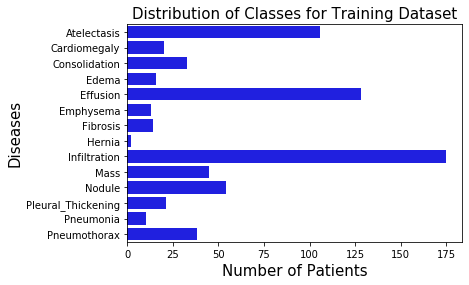

In [5]:
# Plot up the distribution of counts
sns.barplot(class_counts.values, class_counts.index, color='b')
plt.title('Distribution of Classes for Training Dataset', fontsize=15)
plt.xlabel('Number of Patients', fontsize=15)
plt.ylabel('Diseases', fontsize=15)
plt.show()

<a name="weighted-loss"></a>
# Weighted Loss function


Below is an example of calculating weighted loss.  In the assignment, you will calculate a weighted loss function.  This sample code will give you some intuition for what the weighted loss function is doing, and also help you practice some syntax you will use in the assignment.

For this example, you'll first define a hypothetical set of true labels and then a set of predictions.

Run the next cell to create the 'ground truth' labels.

In [6]:
# Generate an array of 4 binary label values, 3 positive and 1 negative
y_true = np.array(
        [[1],
         [1],
         [1],
         [0]])
print(f"y_true: \n{y_true}")

y_true: 
[[1]
 [1]
 [1]
 [0]]


### Two models
To better understand the loss function, you will pretend that you have two models.
- Model 1 always outputs a 0.9 for any example that it's given.  
- Model 2 always outputs a 0.1 for any example that it's given.

In [7]:
# Make model predictions that are always 0.9 for all examples
y_pred_1 = 0.9 * np.ones(y_true.shape)
print(f"y_pred_1: \n{y_pred_1}")
print()
y_pred_2 = 0.1 * np.ones(y_true.shape)
print(f"y_pred_2: \n{y_pred_2}")

y_pred_1: 
[[0.9]
 [0.9]
 [0.9]
 [0.9]]

y_pred_2: 
[[0.1]
 [0.1]
 [0.1]
 [0.1]]


### Problems with the regular loss function
The learning goal here is to notice that with a regular loss function (not a weighted loss), the model that always outputs 0.9 has a smaller loss (performs better) than model 2.
- This is because there is a class imbalance, where 3 out of the 4 labels are 1.
- If the data were perfectly balanced, (two labels were 1, and two labels were 0), model 1 and model 2 would have the same loss.  Each would get two examples correct and two examples incorrect.
- However, since the data is not balanced, the regular loss function implies that model 1 is better than model 2.

### Notice the shortcomings of a regular non-weighted loss

See what loss you get from these two models (model 1 always predicts 0.9, and model 2 always predicts 0.1), see what the regular (unweighted) loss function is for each model.

In [8]:
loss_reg_1 = -1 * np.sum(y_true * np.log(y_pred_1)) + \
                -1 * np.sum((1 - y_true) * np.log(1 - y_pred_1))
print(f"loss_reg_1: {loss_reg_1:.4f}")

loss_reg_1: 2.6187


In [9]:
loss_reg_2 = -1 * np.sum(y_true * np.log(y_pred_2)) + \
                -1 * np.sum((1 - y_true) * np.log(1 - y_pred_2))
print(f"loss_reg_2: {loss_reg_2:.4f}")

loss_reg_2: 7.0131


In [10]:
print(f"When the model 1 always predicts 0.9, the regular loss is {loss_reg_1:.4f}")
print(f"When the model 2 always predicts 0.1, the regular loss is {loss_reg_2:.4f}")

When the model 1 always predicts 0.9, the regular loss is 2.6187
When the model 2 always predicts 0.1, the regular loss is 7.0131


Notice that the loss function gives a greater loss when the predictions are always 0.1, because the data is imbalanced, and has three labels of `1` but only one label for `0`.

Given a class imbalance with more positive labels, the regular loss function implies that the model with the higher prediction of 0.9 performs better than the model with the lower prediction of 0.1

### How a weighted loss treats both models the same
With a weighted loss function, you will get the same weighted loss when the predictions are all 0.9 versus when the predictions are all 0.1.  
- Notice how a prediction of 0.9 is 0.1 away from the positive label of 1.
- Also notice how a prediction of 0.1 is 0.1 away from the negative label of 0
- So model 1 and 2 are "symmetric" along the midpoint of 0.5, if you plot them on a number line between 0 and 1.

### Weighted Loss Equation
Calculate the loss for the zero-th label (column at index 0)

- The loss is made up of two terms.  To make it easier to read the code, you will calculate each of these terms separately.  We are giving each of these two terms a name for explanatory purposes, but these are not officially called $loss_{pos}$ or $loss_{neg}$

    - $loss_{pos}$: we'll use this to refer to the loss where the actual label is positive (the positive examples).
    - $loss_{neg}$: we'll use this to refer to the loss where the actual label is negative (the negative examples).  

$$ loss^{(i)} = loss_{pos}^{(i)} + los_{neg}^{(i)} $$

$$loss_{pos}^{(i)} = -1 \times weight_{pos}^{(i)} \times y^{(i)} \times log(\hat{y}^{(i)})$$

$$loss_{neg}^{(i)} = -1 \times weight_{neg}^{(i)} \times (1- y^{(i)}) \times log(1 - \hat{y}^{(i)})$$

Since this sample dataset is small enough, you can calculate the positive weight to be used in the weighted loss function.  To get the positive weight, count how many NEGATIVE labels are present, divided by the total number of examples.

In this case, there is one negative label, and four total examples.

Similarly, the negative weight is the fraction of positive labels.

Run the next cell to define positive and negative weights.

In [11]:
# calculate the positive weight as the fraction of negative labels
w_p = 1/4

# calculate the negative weight as the fraction of positive labels
w_n = 3/4

print(f"positive weight w_p: {w_p}")
print(f"negative weight w_n {w_n}")

positive weight w_p: 0.25
negative weight w_n 0.75


### Model 1 weighted loss
Run the next two cells to calculate the two loss terms separately.

Here, `loss_1_pos` and `loss_1_neg` are calculated using the `y_pred_1` predictions.

In [12]:
# Calculate and print out the first term in the loss function, which we are calling 'loss_pos'
loss_1_pos = -1 * np.sum(w_p * y_true * np.log(y_pred_1 ))
print(f"loss_1_pos: {loss_1_pos:.4f}")

loss_1_pos: 0.0790


In [13]:
# Calculate and print out the second term in the loss function, which we're calling 'loss_neg'
loss_1_neg = -1 * np.sum(w_n * (1 - y_true) * np.log(1 - y_pred_1 ))
print(f"loss_1_neg: {loss_1_neg:.4f}")

loss_1_neg: 1.7269


In [14]:
# Sum positive and negative losses to calculate total loss
loss_1 = loss_1_pos + loss_1_neg
print(f"loss_1: {loss_1:.4f}")

loss_1: 1.8060


### Model 2 weighted loss

Now do the same calculations for when the predictions are from `y_pred_2'.  Calculate the two terms of the weighted loss function and add them together.

In [15]:
# Calculate and print out the first term in the loss function, which we are calling 'loss_pos'
loss_2_pos = -1 * np.sum(w_p * y_true * np.log(y_pred_2))
print(f"loss_2_pos: {loss_2_pos:.4f}")

loss_2_pos: 1.7269


In [16]:
# Calculate and print out the second term in the loss function, which we're calling 'loss_neg'
loss_2_neg = -1 * np.sum(w_n * (1 - y_true) * np.log(1 - y_pred_2))
print(f"loss_2_neg: {loss_2_neg:.4f}")

loss_2_neg: 0.0790


In [17]:
# Sum positive and negative losses to calculate total loss when the prediction is y_pred_2
loss_2 = loss_2_pos + loss_2_neg
print(f"loss_2: {loss_2:.4f}")

loss_2: 1.8060


### Compare model 1 and model 2 weighted loss

In [18]:
print(f"When the model always predicts 0.9, the total loss is {loss_1:.4f}")
print(f"When the model always predicts 0.1, the total loss is {loss_2:.4f}")

When the model always predicts 0.9, the total loss is 1.8060
When the model always predicts 0.1, the total loss is 1.8060


### What do you notice?
Since you used a weighted loss, the calculated loss is the same whether the model always predicts 0.9 or always predicts 0.1.  

You may have also noticed that when you calculate each term of the weighted loss separately, there is a bit of symmetry when comparing between the two sets of predictions.

In [19]:
print(f"loss_1_pos: {loss_1_pos:.4f} \t loss_1_neg: {loss_1_neg:.4f}")
print()
print(f"loss_2_pos: {loss_2_pos:.4f} \t loss_2_neg: {loss_2_neg:.4f}")

loss_1_pos: 0.0790 	 loss_1_neg: 1.7269

loss_2_pos: 1.7269 	 loss_2_neg: 0.0790


Even though there is a class imbalance, where there are 3 positive labels but only one negative label, the weighted loss accounts for this by giving more weight to the negative label than to the positive label.

### Weighted Loss for more than one class

In this assignment, you will calculate the multi-class weighted loss (when there is more than one disease class that your model is learning to predict).  Here, you can practice working with 2D numpy arrays, which will help you implement the multi-class weighted loss in the assignment.

You will work with a dataset that has two disease classes (two columns)

In [20]:
# View the labels (true values) that you will practice with
y_true = np.array(
        [[1,0],
         [1,0],
         [1,0],
         [1,0],
         [0,1]
        ])
y_true

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1]])

### Choosing axis=0 or axis=1
You will use `numpy.sum` to count the number of times column `0` has the value 0.  
First, notice the difference when you set axis=0 versus axis=1

In [21]:
# See what happens when you set axis=0
print(f"using axis = 0 {np.sum(y_true,axis=0)}")

# Compare this to what happens when you set axis=1
print(f"using axis = 1 {np.sum(y_true,axis=1)}")

using axis = 0 [4 1]
using axis = 1 [1 1 1 1 1]


Notice that if you choose `axis=0`, the sum is taken for each of the two columns.  This is what you want to do in this case. If you set `axis=1`, the sum is taken for each row.

### Calculate the weights
Previously, you visually inspected the data to calculate the fraction of negative and positive labels.  Here, you can do this programmatically.

In [22]:
# set the positive weights as the fraction of negative labels (0) for each class (each column)
w_p = np.sum(y_true == 0,axis=0) / y_true.shape[0]
w_p

array([0.2, 0.8])

In [23]:
# set the negative weights as the fraction of positive labels (1) for each class
w_n = np.sum(y_true == 1, axis=0) / y_true.shape[0]
w_n

array([0.8, 0.2])

In the assignment, you will train a model to try and make useful predictions.  In order to make this example easier to follow, you will pretend that your model always predicts the same value for every example.

In [24]:
# Set model predictions where all predictions are the same
y_pred = np.ones(y_true.shape)
y_pred[:,0] = 0.3 * y_pred[:,0]
y_pred[:,1] = 0.7 * y_pred[:,1]
y_pred

array([[0.3, 0.7],
       [0.3, 0.7],
       [0.3, 0.7],
       [0.3, 0.7],
       [0.3, 0.7]])

As before, calculate the two terms that make up the loss function.  Notice that you are working with more than one class (represented by columns).  In this case, there are two classes.

Start by calculating the loss for class `0`.

$$ loss^{(i)} = loss_{pos}^{(i)} + los_{neg}^{(i)} $$

$$loss_{pos}^{(i)} = -1 \times weight_{pos}^{(i)} \times y^{(i)} \times log(\hat{y}^{(i)})$$

$$loss_{neg}^{(i)} = -1 \times weight_{neg}^{(i)} \times (1- y^{(i)}) \times log(1 - \hat{y}^{(i)})$$

View the zero column for the weights, true values, and predictions that you will use to calculate the loss from the positive predictions.

In [25]:
# Print and view column zero of the weight
print(f"w_p[0]: {w_p[0]}")
print(f"y_true[:,0]: {y_true[:,0]}")
print(f"y_pred[:,0]: {y_pred[:,0]}")

w_p[0]: 0.2
y_true[:,0]: [1 1 1 1 0]
y_pred[:,0]: [0.3 0.3 0.3 0.3 0.3]


In [26]:
# calculate the loss from the positive predictions, for class 0
loss_0_pos = -1 * np.sum(w_p[0] * 
                y_true[:, 0] * 
                np.log(y_pred[:, 0])
              )
print(f"loss_0_pos: {loss_0_pos:.4f}")

loss_0_pos: 0.9632


View the zero column for the weights, true values, and predictions that you will use to calculate the loss from the negative predictions.

In [27]:
# Print and view column zero of the weight
print(f"w_n[0]: {w_n[0]}")
print(f"y_true[:,0]: {y_true[:,0]}")
print(f"y_pred[:,0]: {y_pred[:,0]}")

w_n[0]: 0.8
y_true[:,0]: [1 1 1 1 0]
y_pred[:,0]: [0.3 0.3 0.3 0.3 0.3]


In [28]:
# Calculate the loss from the negative predictions, for class 0
loss_0_neg = -1 * np.sum( 
                w_n[0] * 
                (1 - y_true[:, 0]) * 
                np.log(1 - y_pred[:, 0])
              )
print(f"loss_0_neg: {loss_0_neg:.4f}")

loss_0_neg: 0.2853


In [29]:
# add the two loss terms to get the total loss for class 0
loss_0 = loss_0_neg + loss_0_pos
print(f"loss_0: {loss_0:.4f}")

loss_0: 1.2485


Now you are familiar with the array slicing that you would use when there are multiple disease classes stored in a two-dimensional array.

#### Now it's your turn!
* Can you calculate the loss for class (column) `1`?  

In [30]:
# calculate the loss from the positive predictions, for class 1
loss_1_pos = None

Expected output
```CPP
loss_1_pos: 0.2853
```

In [31]:
# Calculate the loss from the negative predictions, for class 1
loss_1_neg = None

#### Expected output
```CPP
loss_1_neg: 0.9632
```

In [32]:
# add the two loss terms to get the total loss for class 0
loss_1 = None

#### Expected output
```CPP
loss_1: 1.2485
```

### Note
The data for the two classes (two columns) as well as the predictions were chosen so that you end up getting the same weighted loss for both categories.  
 - In general, you will expect to calculate different weighted loss values for each disease category, as the model predictions and data will differ from one category to another.

If you want some help, please click on the green "Solution" cell below to reveal the solution.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Solution</b></font>
</summary>
<p>
<code>
-- # calculate the loss from the positive predictions, for class 1
loss_1_pos = -1 * np.sum(w_p[1] * 
                y_true[:, 1] * 
                np.log(y_pred[:, 1])
              )
print(f"loss_1_pos: {loss_1_pos:.4f}")
    
-- # Calculate the loss from the negative predictions, for class 1
loss_1_neg = -1 * np.sum( 
                w_n[1] * 
                (1 - y_true[:, 1]) * 
                np.log(1 - y_pred[:, 1])
              )
print(f"loss_1_neg: {loss_1_neg:.4f}")

-- # add the two loss terms to get the total loss for class 1
loss_1 = loss_1_neg + loss_1_pos
print(f"loss_1: {loss_1:.4f}")
    </code>
</p>


### How this practice relates to and differs from the upcoming assignment
- In the assignment, you will generalize this to calculating the loss for any number of classes.
- Also in the assignment, you will learn how to avoid taking the log of zero by adding a small number (more details will be explained in the assignment).
- Note that in this lecture notebook, you are taking the **sum** of losses for all examples.  In the assignment, you will take the **average (the mean)** for all examples.
- Finally, in the assignment, you will work with "tensors" in TensorFlow, so you will use the TensorFlow equivalents of the numpy operations (keras.mean instead of numpy.mean).

#### That's all for this lab. You now have a couple more tools you'll need for this week's assignment! :) 